# Detecting Switches  
> This module provides tools to identify potential isoform switches within single-cell isoform-resolution datasets. It includes methods based on Dirichlet distributions and Wilcoxon tests for detecting differential isoform usage. These approaches are still under development and intended for exploratory use, with manual confirmation of detected isoform switches being essential.  


In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| default_exp switch_search

In [3]:
#| export
import anndata as ad

In [4]:
#| export
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.optimize import minimize
from itertools import combinations
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import anndata as ad
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###############################################################################
# Helper functions
###############################################################################
def _is_log_transformed(data):
    """
    Heuristic to decide if a data array is log-transformed.
    Checks the fraction of nonzero entries that deviate from an integer value.
    """
    nonzero = data[data > 0]
    if nonzero.size == 0:
        return False
    # If more than 10% of nonzero values are not (nearly) integers, assume log-transformed.
    fraction_noninteger = np.mean(np.abs(nonzero - np.round(nonzero)) > 1e-3)
    return fraction_noninteger > 0.1

def _dirichlet_multinomial_nll(alpha, data_np):
    if np.any(alpha <= 0):
        return np.inf
    alpha_sum = np.sum(alpha)
    nll = 0.0
    for row in data_np:
        N = np.sum(row)
        nll -= gammaln(alpha_sum)
        nll += gammaln(alpha_sum + N)
        for j in range(len(alpha)):
            nll -= gammaln(alpha[j] + row[j]) - gammaln(alpha[j])
    return float(nll)

def _dm_mle(data):
    K = data.shape[1]
    def objective(alpha):
        return _dirichlet_multinomial_nll(alpha, data)
    init_alpha = np.ones(K) + 0.1
    bounds = [(1e-9, None)] * K
    result = minimize(fun=objective, x0=init_alpha, method='L-BFGS-B',
                      bounds=bounds, options={'maxiter': 10000, 'ftol': 1e-5})
    if not result.success:
        return float('nan'), np.zeros(K)
    return float(result.fun), result.x

###############################################################################
# The SwitchSearch class: Core isoform switch detection functionality.
###############################################################################
class SwitchSearch(sc.AnnData):
    def __init__(self, anndata: ad.AnnData):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        self.relevant_genes = None
        # Caches for single–group and combined fits
        self._single_fit_cache = {}    
        self._combined_fit_cache = {}  
        # Initialize as an actual AnnData object (a copy is stored)
        self._init_as_actual(anndata.copy())
        # Ensure a transcript identifier exists.
        if 'transcriptId' not in self.var_keys():
            self.var['transcriptId'] = self.var.index

    # --- Internal functions for the Dirichlet test ---
    def __fit_single_group(self, group_label, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label, gene_id)
        if cache_key in self._single_fit_cache:
            return self._single_fit_cache[cache_key]
        group_data = self[self.obs[cell_group_column] == group_label]
        if 'geneId' not in group_data.var.columns:
            return (np.nan, None)
        mask_gene = (group_data.var['geneId'] == gene_id)
        data = group_data[:, mask_gene].X.toarray()
        if _is_log_transformed(data):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts = data.sum(axis=1)
        data = data[total_counts > 9]
        if data.shape[0] == 0:
            self._single_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        nll, alpha = _dm_mle(data)
        self._single_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __fit_combined(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label1, group_label2, gene_id)
        if cache_key in self._combined_fit_cache:
            return self._combined_fit_cache[cache_key]
        # Group 1
        group1 = self[self.obs[cell_group_column] == group_label1]
        if 'geneId' not in group1.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask1 = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask1].X.toarray()
        if _is_log_transformed(data1):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts1 = data1.sum(axis=1)
        data1 = data1[total_counts1 > 9]
        # Group 2
        group2 = self[self.obs[cell_group_column] == group_label2]
        if 'geneId' not in group2.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask2].X.toarray()
        if _is_log_transformed(data2):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts2 = data2.sum(axis=1)
        data2 = data2[total_counts2 > 9]
        if data1.shape[0] == 0 or data2.shape[0] == 0:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        combined_data = np.vstack([data1, data2])
        nll, alpha = _dm_mle(combined_data)
        self._combined_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __cached_LRT_test(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        loss1, alpha1 = self.__fit_single_group(group_label1, gene_id, cell_group_column)
        loss2, alpha2 = self.__fit_single_group(group_label2, gene_id, cell_group_column)
        if alpha1 is None or alpha2 is None or np.isnan(loss1) or np.isnan(loss2):
            return None
        loss_full, alpha_full = self.__fit_combined(group_label1, group_label2, gene_id, cell_group_column)
        if alpha_full is None or np.isnan(loss_full):
            return None
        chi2_stat = 2.0 * (loss_full - (loss1 + loss2))
        if chi2_stat < 0:
            return None
        K = len(alpha_full)
        p_value = 1.0 - chi2.cdf(chi2_stat, df=K)
        return chi2_stat, p_value  # (we no longer need the alphas)

    def __compare_groups(self, group_1_label, group_2_label, cell_group_column, gene_id):
        """
        For the Dirichlet test, returns a list of transcript-wise result dictionaries.
        For a given gene contrast, we compute:
          - p_value and chi2_stat from the LRT (gene-level)
          - For each transcript in that gene: average usage (mean proportion) in each group,
            percent expressed in each group, and a log fold change.
          - Also include cell counts and the gene_id.
        """
        test_result = self.__cached_LRT_test(group_1_label, group_2_label, gene_id, cell_group_column)
        if test_result is None:
            return None
        chi2_stat, p_value = test_result
        # Get group1 data for this gene:
        group1 = self[self.obs[cell_group_column] == group_1_label]
        mask_gene = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask_gene].X.toarray()
        total_counts1 = data1.sum(axis=1)
        cells1 = data1[total_counts1 > 9]
        # Group2 data:
        group2 = self[self.obs[cell_group_column] == group_2_label]
        mask_gene2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask_gene2].X.toarray()
        total_counts2 = data2.sum(axis=1)
        cells2 = data2[total_counts2 > 9]
        if cells1.shape[0] == 0 or cells2.shape[0] == 0:
            return None
        n_cells_group_1 = cells1.shape[0]
        n_cells_group_2 = cells2.shape[0]
        total_cells = n_cells_group_1 + n_cells_group_2
        # Get transcript IDs – assume the order is the same in both groups.
        transcript_ids = self.var.loc[self.var['geneId'] == gene_id, 'transcriptId'].values
        # Compute transcript–level metrics:
        def compute_metrics(counts):
            gene_totals = counts.sum(axis=1, keepdims=True)
            proportions = counts / gene_totals  # cell-wise proportions
            avg_usage = proportions.mean(axis=0)
            pct_expressed = (counts > 0).mean(axis=0) * 100
            return avg_usage, pct_expressed
        avg_usage1, pct_expr1 = compute_metrics(cells1)
        avg_usage2, pct_expr2 = compute_metrics(cells2)
        log_fc = np.log((avg_usage1 + 1e-6) / (avg_usage2 + 1e-6))
        contrast = f"{group_1_label}__{group_2_label}"
        results = []
        for j, tid in enumerate(transcript_ids):
            result_dict = {
                "gene_id": gene_id,
                "transcript_id": tid,
                "group_1": group_1_label,
                "group_2": group_2_label,
                "contrast": contrast,
                "p_value": p_value,
                "chi2_stat": chi2_stat,
                "log_fold_change": log_fc[j],
                "avg_usage_group_1": avg_usage1[j],
                "avg_usage_group_2": avg_usage2[j],
                "n_cells_group_1": n_cells_group_1,
                "n_cells_group_2": n_cells_group_2,
                "total_cells": total_cells,
                "percent_expressed_group_1": pct_expr1[j],
                "percent_expressed_group_2": pct_expr2[j]
            }
            results.append(result_dict)
        return results

    def __filter_genes(self, group_1_label, group_2_label, cell_group_column,
                         min_count=9, min_diff=0.1, filter_loud=False):
        group_1 = self[self.obs[cell_group_column] == group_1_label]
        group_2 = self[self.obs[cell_group_column] == group_2_label]
        gene_counts_1 = np.array(group_1.X.sum(axis=0)).flatten()
        gene_counts_2 = np.array(group_2.X.sum(axis=0)).flatten()
        total_gene_counts = gene_counts_1 + gene_counts_2
        valid_genes_mask = total_gene_counts > min_count
        if filter_loud:
            n_genes_initial = self.shape[1]
            n_genes_passing_count = np.sum(valid_genes_mask)
            print(f"[filter_genes] Genes passing count threshold: {n_genes_passing_count} / {n_genes_initial}")
        adata_slice = self[:, valid_genes_mask]
        group_1_slice = adata_slice[adata_slice.obs[cell_group_column] == group_1_label]
        group_2_slice = adata_slice[adata_slice.obs[cell_group_column] == group_2_label]
        nz1 = (group_1_slice.X != 0).sum(axis=0) > min_count
        nz2 = (group_2_slice.X != 0).sum(axis=0) > min_count
        final_valid_genes = nz1 & nz2
        if filter_loud:
            print(f"[filter_genes] Genes with sufficient nonzero counts in both groups: {np.sum(final_valid_genes)}")
        filtered_data = adata_slice[:, final_valid_genes]
        unique_gene_ids = np.unique(filtered_data.var['geneId'])
        to_remove = []
        for gene_id in unique_gene_ids:
            sub1 = filtered_data[(filtered_data.obs[cell_group_column] == group_1_label),
                                 (filtered_data.var['geneId'] == gene_id)]
            sub2 = filtered_data[(filtered_data.obs[cell_group_column] == group_2_label),
                                 (filtered_data.var['geneId'] == gene_id)]
            X1 = sub1.X.astype(float).toarray()
            X2 = sub2.X.astype(float).toarray()
            if X1.sum() == 0 or X2.sum() == 0:
                to_remove.append(gene_id)
                continue
            percent_1 = X1 / X1.sum()
            percent_2 = X2 / X2.sum()
            diff_found = any(abs(percent_1[:, j].sum() - percent_2[:, j].sum()) > min_diff 
                             for j in range(percent_1.shape[1]))
            if not diff_found:
                to_remove.append(gene_id)
        filtered_data = filtered_data[:, ~filtered_data.var['geneId'].isin(to_remove)]
        return SwitchSearch(filtered_data)

    # --- Internal function for the Wilcoxon test ---
    def __scanpy_wilcoxon_switching_isoforms(self, cell_labels_column='cell_type',
                                               min_fdr=0.05, min_log_fold_change=0.3):
        # Work on a separate copy for normalization so the original data isn’t altered.
        adata_norm = self.copy()
        if adata_norm.shape[0] == 0:
            return pd.DataFrame()
        if 'transcriptId' not in adata_norm.var.columns:
            adata_norm.var['transcriptId'] = adata_norm.var_names
        adata_norm.obs[cell_labels_column] = adata_norm.obs[cell_labels_column].astype('category')
        if hasattr(adata_norm.X, "toarray"):
            X_dense = adata_norm.X.toarray()
        else:
            X_dense = adata_norm.X
        if not _is_log_transformed(X_dense):
            lib_sizes = X_dense.sum(axis=1, keepdims=True)
            lib_sizes[lib_sizes == 0] = 1
            X_norm = (X_dense / lib_sizes) * 1e6
            adata_norm.X = np.log1p(X_norm)
        groups = adata_norm.obs[cell_labels_column].cat.categories
        if len(groups) < 2:
            return pd.DataFrame()
        marker_results_list = {}
        for group_1, group_2 in combinations(groups, 2):
            try:
                sc.tl.rank_genes_groups(
                    adata_norm, groupby=cell_labels_column, groups=[group_1],
                    reference=group_2, method='wilcoxon', n_genes=adata_norm.shape[0]
                )
                df1 = sc.get.rank_genes_groups_df(adata_norm, group=group_1)
                df1['group_1'] = group_1
                df1['group_2'] = group_2
                df1['contrast'] = f"{group_1}__{group_2}"
        
                sc.tl.rank_genes_groups(
                    adata_norm, groupby=cell_labels_column, groups=[group_2],
                    reference=group_1, method='wilcoxon', n_genes=adata_norm.shape[0]
                )
                df2 = sc.get.rank_genes_groups_df(adata_norm, group=group_2)
                df2['group_1'] = group_2
                df2['group_2'] = group_1
                df2['contrast'] = f"{group_1}__{group_2}"
        
                if not df1.empty and not df2.empty:
                    marker_results_list[df1['contrast'].iloc[0]] = pd.concat([df1, df2], ignore_index=True)
            except ValueError:
                continue
        if not marker_results_list:
            return pd.DataFrame()
        marker_df = pd.concat(marker_results_list.values(), ignore_index=True)
        transcript_to_gene = adata_norm.var.set_index('transcriptId')['geneId'].to_dict()
        marker_df['geneId'] = marker_df['names'].map(transcript_to_gene)
        cell_counts = adata_norm.obs[cell_labels_column].value_counts()
        marker_df['n_cells_group_1'] = marker_df['group_1'].map(cell_counts)
        marker_df['n_cells_group_2'] = marker_df['group_2'].map(cell_counts)
        marker_df['total_cells'] = marker_df['n_cells_group_1'] + marker_df['n_cells_group_2']
        marker_df['adj_pval'] = multipletests(marker_df['pvals_adj'], method='fdr_bh')[1]
        marker_df_filtered = marker_df[
            (marker_df['adj_pval'] <= min_fdr) &
            (marker_df['logfoldchanges'].abs() >= min_log_fold_change)
        ]
        def assign_direction(df):
            return df.assign(
                direction=np.where(
                    df['group_1'] == df['contrast'].str.split("__").str[0],
                    df['logfoldchanges'],
                    -df['logfoldchanges']
                )
            )
        isoswitch_df = (
            marker_df_filtered
            .groupby(['geneId', 'contrast'])
            .apply(assign_direction)
            .reset_index(drop=True)
            .groupby(['geneId', 'contrast'])
            .filter(lambda x: (
                len(x['group_1'].unique()) > 1 and
                len(x['names'].unique()) > 1 and
                x['direction'].abs().sum() != 0
            ))
        )
        def calculate_percent_expression(adata, groupby_column, group, transcript):
            subset = adata[adata.obs[groupby_column] == group, transcript]
            return (subset.X > 0).mean() * 100
        percent_expressions = isoswitch_df.apply(
            lambda row: pd.Series({
                'percent_expressed_group_1': calculate_percent_expression(adata_norm, cell_labels_column, row['group_1'], row['names']),
                'percent_expressed_group_2': calculate_percent_expression(adata_norm, cell_labels_column, row['group_2'], row['names'])
            }),
            axis=1
        )
        isoswitch_df = pd.concat([isoswitch_df, percent_expressions], axis=1)
        isoswitch_df.sort_values(by='adj_pval', inplace=True)
        isoswitch_df = isoswitch_df.rename(columns={
            "geneId": "gene_id",
            "names": "transcript_id",
            "logfoldchanges": "log_fold_change",
            "adj_pval": "p_value"
        })
        cols_order = ["gene_id", "transcript_id", "group_1", "group_2", "contrast",
                      "p_value", "log_fold_change", "n_cells_group_1", "n_cells_group_2",
                      "total_cells", "percent_expressed_group_1", "percent_expressed_group_2"]
        isoswitch_df = isoswitch_df[[col for col in cols_order if col in isoswitch_df.columns]]
        return isoswitch_df

    # --- Public methods for switch tests ---
    def find_switching_isoforms_dirichlet(self,
                                          cell_group_column='cell_type',
                                          min_count=30,
                                          min_diff=0.2,
                                          filter_loud=False):
        """
        Identifies switching isoforms using the Dirichlet–based likelihood ratio test.
        Ensures that the input data are raw counts (not log-transformed).
        Returns a DataFrame with transcript-level rows and columns:
          gene_id, transcript_id, group_1, group_2, contrast,
          p_value, chi2_stat, log_fold_change, avg_usage_group_1, avg_usage_group_2,
          n_cells_group_1, n_cells_group_2, total_cells,
          percent_expressed_group_1, percent_expressed_group_2
        """
        if 'geneId' not in self.var.columns:
            return pd.DataFrame()
        cell_types = self.obs[cell_group_column].unique()
        gene_ids = self.var['geneId'].unique()
        results = []
        for g1, g2 in combinations(cell_types, 2):
            filtered_adata = self.__filter_genes(
                g1, g2,
                cell_group_column=cell_group_column,
                min_count=min_count,
                min_diff=min_diff,
                filter_loud=filter_loud
            )
            for gene_id in gene_ids:
                if gene_id not in filtered_adata.var['geneId'].values:
                    continue
                res = filtered_adata.__compare_groups(g1, g2, cell_group_column, gene_id)
                if res is not None:
                    results.extend(res)
        results_df = pd.DataFrame(results)
        cols_order = ["gene_id", "transcript_id", "group_1", "group_2", "contrast",
                      "p_value", "chi2_stat", "log_fold_change", "avg_usage_group_1", "avg_usage_group_2",
                      "n_cells_group_1", "n_cells_group_2", "total_cells",
                      "percent_expressed_group_1", "percent_expressed_group_2"]
        results_df = results_df[[col for col in cols_order if col in results_df.columns]]
        self.relevant_genes = results_df
        return results_df

    def find_switching_isoforms_wilcoxon(self,
                                         cell_group_column='cell_type',
                                         min_fdr=0.05,
                                         min_log_fold_change=0.5):
        """
        Identifies switching isoforms using Scanpy's rank_genes_groups with a Wilcoxon test.
        Ensures that the data are CPM normalized and log-transformed before testing.
        Returns a DataFrame with columns:
          gene_id, transcript_id, group_1, group_2, contrast,
          p_value, log_fold_change, n_cells_group_1, n_cells_group_2,
          total_cells, percent_expressed_group_1, percent_expressed_group_2
        """
        return self.__scanpy_wilcoxon_switching_isoforms(
            cell_labels_column=cell_group_column,
            min_fdr=min_fdr,
            min_log_fold_change=min_log_fold_change
        )


In [5]:
# | export
def create_iso_adata(
    path: str  # Path to a tab-separated file, typically the Sicelore output with transcript counts.
):
    """
    Creates an AnnData object containing isoform counts from a Sicelore output file.

    Parameters:
    - path (str): Path to the input file, which is expected to be tab-separated and contain:
        - `transcriptId`: Transcript identifiers.
        - `geneId`: Gene identifiers.
        - Transcript counts for individual barcodes (cells) as additional columns.

    Returns:
    - adata_iso (AnnData): An AnnData object with isoform counts.
    """

    # Open the input file and read it into a Pandas DataFrame
    with open(path) as isoforms:
        df = pd.read_table(isoforms, sep='\t')

    # Extract the count matrix
    # - `df.iloc[0:, 2:]`: assuming these are counts.
    counts = df.iloc[0:, 2:]

    # Create an AnnData object with the count matrix

    adata_iso = ad.AnnData(counts).transpose()

    # Assign transcript IDs as variable names (columns in the original file)
    adata_iso.var_names = df['transcriptId'].to_list()

    # Add additional variable-level metadata
    # - Include both `transcriptId` and `geneId` as annotations for the variables.
    adata_iso.var = df[['transcriptId', 'geneId']]

    # Create observation-level metadata for barcodes (cells)
    # - Extract column names (barcodes) starting from the 3rd column (index 2).
    barcodes = {'barcodes': df.columns.values[2:]}
    barcodes = pd.DataFrame(data=barcodes)

    # Assign the barcodes DataFrame to the AnnData object as observation metadata
    adata_iso.obs = barcodes

    # Set observation names (row indices) in the AnnData object to match the barcodes
    adata_iso.obs_names = barcodes['barcodes'].tolist()

    # Return the AnnData object containing isoform counts
    return adata_iso

In [6]:
from allos.readers_tests import *
import allos.preprocessing as pp
combined_mouse_data = process_mouse_data()
combined_mouse_data = pp.filter_transcripts_by_abundance(combined_mouse_data,  threshold_pct= 2)





🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
ss = SwitchSearch(combined_mouse_data)

In [8]:


# Run the Dirichlet–based switch test (will error if data appear log–transformed):
dirichlet_results = ss.find_switching_isoforms_dirichlet(cell_group_column='cell_type',
                                                         min_count=30, min_diff=0.2)

# Run the Wilcoxon–based switch test (will CPM–normalize and log–transform if needed):
wilcoxon_results = ss.find_switching_isoforms_wilcoxon(cell_group_column='cell_type',
                                                       min_fdr=0.05, min_log_fold_change=0.5)


/tmp/ipykernel_339919/4003097478.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marker_df_filtered


In [9]:
dirichlet_results.head(20)

,gene_id,transcript_id,group_1,group_2,contrast,p_value,chi2_stat,log_fold_change,avg_usage_group_1,avg_usage_group_2,n_cells_group_1,n_cells_group_2,total_cells,percent_expressed_group_1,percent_expressed_group_2
0,Clta,ENSMUST00000170241.7,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,9.750177e-08,32.286791,-1.477281,0.187287,0.820513,17,3,20,94.117647,100.000000
1,Clta,ENSMUST00000107849.9,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,9.750177e-08,32.286791,1.510269,0.812713,0.179487,17,3,20,100.000000,33.333333
2,Myl6,ENSMUST00000218127.1,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,5.760069e-02,5.708441,-1.755998,0.119585,0.692308,9,1,10,55.555556,100.000000
3,Myl6,ENSMUST00000164181.1,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,5.760069e-02,5.708441,1.051291,0.880415,0.307692,9,1,10,100.000000,100.000000
4,Pkm,ENSMUST00000163694.3,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.930989e-14,62.319359,2.219692,0.861043,0.093545,37,11,48,100.000000,54.545455
5,Pkm,ENSMUST00000034834.15,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.930989e-14,62.319359,-1.875371,0.138957,0.906455,37,11,48,70.270270,100.000000
6,Mtch1,ENSMUST00000095427.10,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,3.008420e-03,11.612680,0.588384,0.969697,0.538398,3,5,8,100.000000,100.000000
7,Mtch1,ENSMUST00000118366.7,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,3.008420e-03,11.612680,-2.723424,0.030303,0.461602,3,5,8,33.333333,100.000000
8,Myl6,ENSMUST00000218127.1,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.018094e-02,9.174476,-1.477037,0.119585,0.523778,9,11,20,55.555556,90.909091
9,Myl6,ENSMUST00000164181.1,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.018094e-02,9.174476,0.614509,0.880415,0.476222,9,11,20,100.000000,100.000000


In [10]:
wilcoxon_results.head(20)

,gene_id,transcript_id,group_1,group_2,contrast,p_value,log_fold_change,n_cells_group_1,n_cells_group_2,total_cells,percent_expressed_group_1,percent_expressed_group_2
6206,Pkm,ENSMUST00000034834.15,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,5.441936e-29,5.359763,117,275,392,88.888889,42.181818
6207,Pkm,ENSMUST00000163694.3,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,1.645196e-27,5.031865,275,117,392,89.818182,43.589744
6222,Pkm,ENSMUST00000034834.15,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,8.865320e-27,5.971428,86,275,361,94.186047,42.181818
1554,Clta,ENSMUST00000107849.9,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,2.994790e-26,5.032757,275,117,392,87.636364,39.316239
6229,Pkm,ENSMUST00000034834.15,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,1.156183e-24,6.393306,68,275,343,95.588235,42.181818
6228,Pkm,ENSMUST00000163694.3,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.039047e-23,8.153163,275,68,343,89.818182,16.176471
1574,Clta,ENSMUST00000107849.9,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,7.447796e-22,8.955872,275,68,343,87.636364,7.352941
2339,Eef1d,ENSMUST00000154584.8,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,2.569838e-21,6.469005,68,275,343,89.705882,24.727273
6203,Pkm,ENSMUST00000163694.3,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,4.162578e-21,4.570864,234,117,351,84.615385,43.589744
1186,Cdc42,ENSMUST00000030417.9,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.016153e-20,7.493307,275,68,343,85.090909,14.705882


/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 24917 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


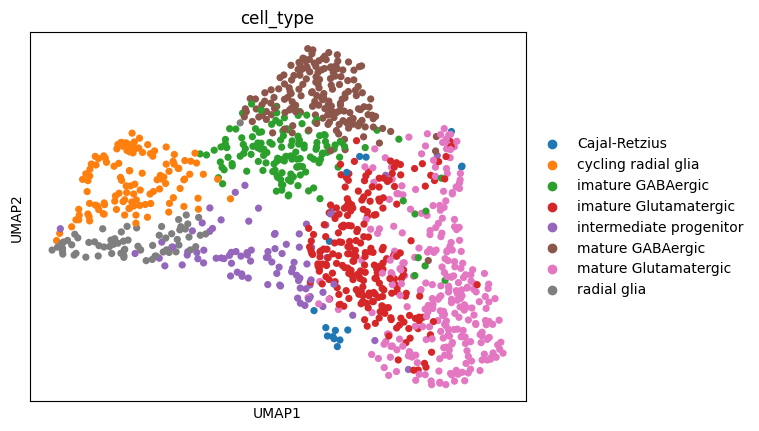

In [11]:
import allos.visuals as vs
sc.pp.normalize_total(combined_mouse_data, target_sum=1e6)
sc.pp.log1p(combined_mouse_data)
sc.pp.neighbors(combined_mouse_data)
sc.tl.umap(combined_mouse_data)
sc.pl.umap(combined_mouse_data, color = 'cell_type')

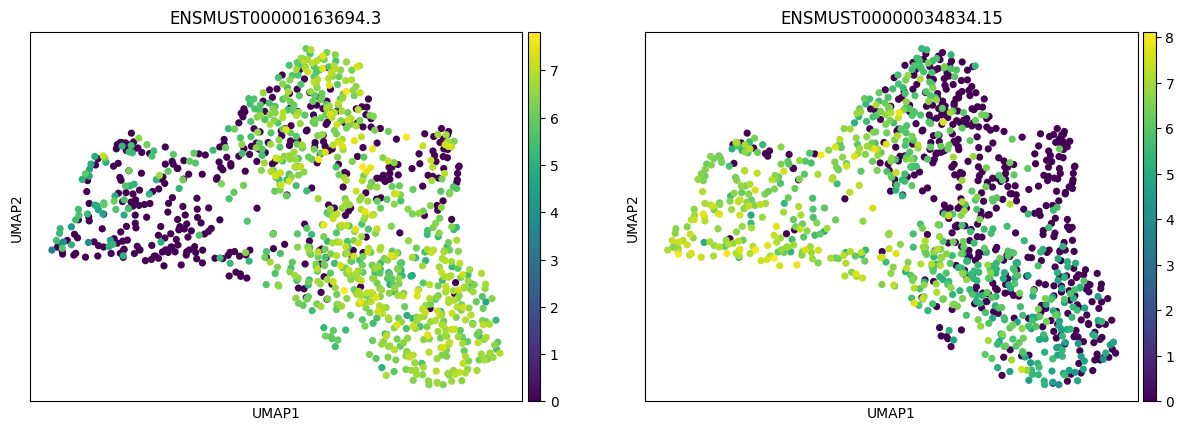

In [12]:
vs.plot_transcripts(combined_mouse_data, gene_id='Pkm')

In [13]:
Pkm_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Pkm'].var.index.to_list()

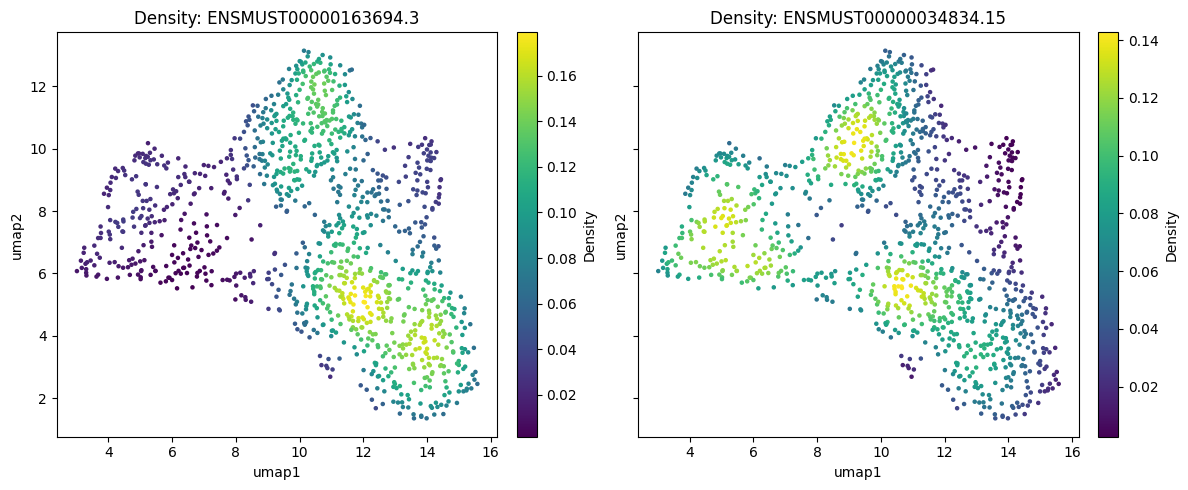

In [14]:
vs.plot_density_multi(combined_mouse_data, features=Pkm_Txs)

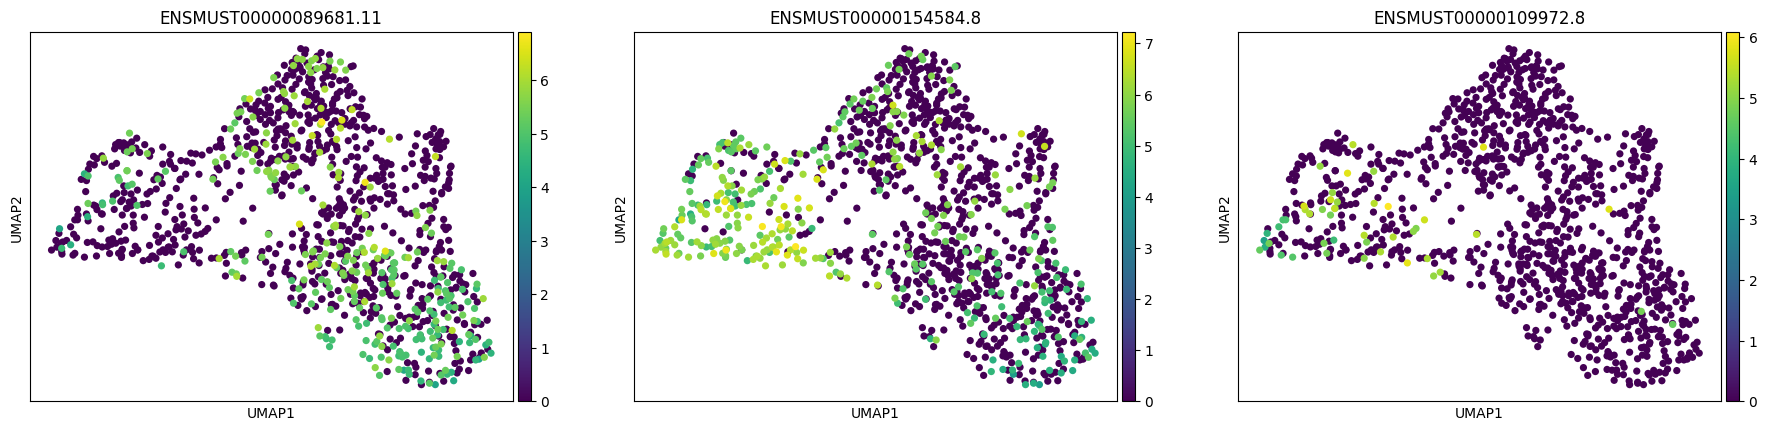

In [15]:
vs.plot_transcripts(combined_mouse_data, gene_id='Eef1d')

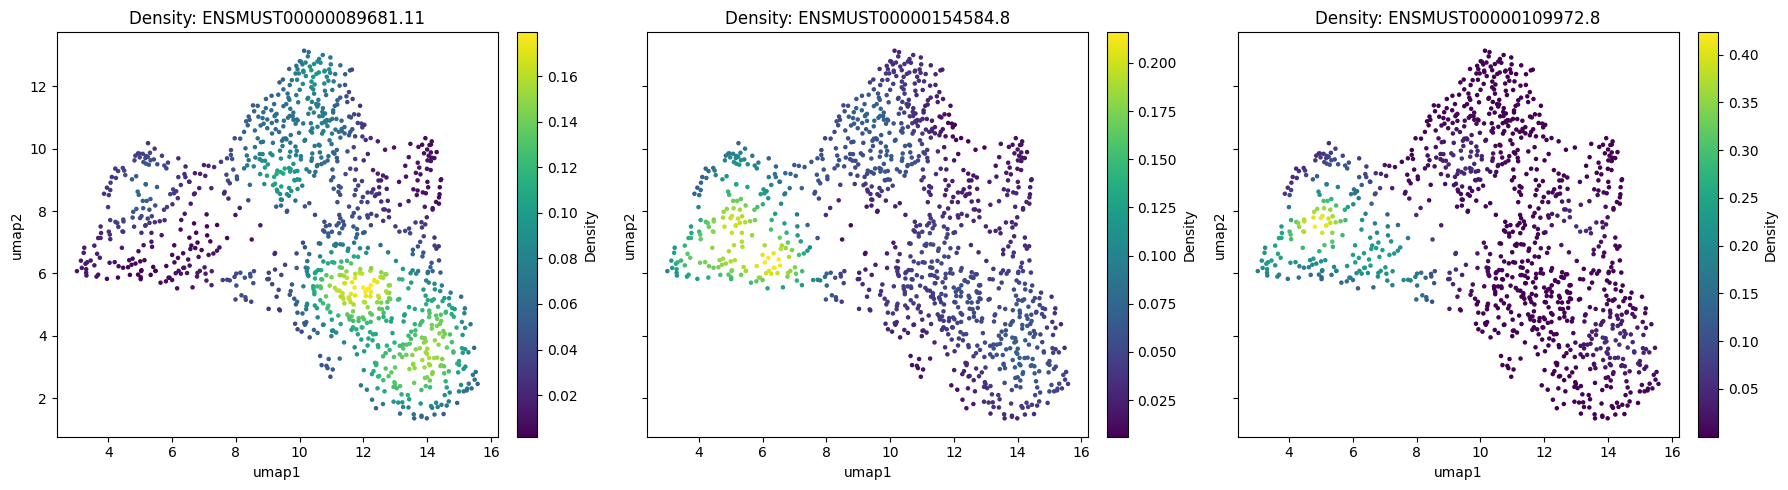

In [16]:
Eef1d_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Eef1d'].var.index.to_list()
vs.plot_density_multi(combined_mouse_data, features=Eef1d_Txs)

In [21]:
#| hide
from nbdev.showdoc import *

In [22]:
#| hide
import nbdev; nbdev.nbdev_export()